<a href="https://colab.research.google.com/github/YawBoah/MSCAssignments/blob/main/inventory_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [ ]:
df = pd.read_csv('/content/Inventory_Data.csv')

In [ ]:
df.head()

,24-01-27,S008,P073,89,99,130,1,13.11,7
0,2024-01-27,S008,P397,187,81,234,9,36.65,4
1,2024-01-27,S008,P002,168,9,155,7,10.77,14
2,2024-01-27,S008,P401,50,62,82,5,29.33,14
3,2024-01-27,S008,P235,108,17,77,1,36.14,5
4,2024-01-27,S008,P096,56,37,81,9,38.43,14


In [ ]:
print(df.columns)

Index(['24-01-27', 'S008', 'P073', '89', '99', '130', '1', '13.11', '7'], dtype='object')


In [ ]:
df.columns = ['date', 'store_id', 'product_id', 'inventory_level', 'quantity_sold',
              'sales_amount', 'promotion_flag', 'temperature_c', 'weather_code']


In [ ]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Pick one product and store (you can loop through later)
store = 'S008'
product = 'P073'

filtered_df = df[(df['store_id'] == store) & (df['product_id'] == product)]

# Group daily demand
demand = filtered_df.groupby('date')['quantity_sold'].sum().reset_index()
demand.rename(columns={'date': 'ds', 'quantity_sold': 'y'}, inplace=True)

# Check sample
demand.tail()


,ds,y
3,2024-04-01,11
4,2024-04-09,81
5,2024-05-10,76
6,2024-06-26,37
7,2024-09-15,14


In [ ]:
model = Prophet(daily_seasonality=True)
model.fit(demand)

# Predict for next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Add rolling demand & std for inventory logic
lead_time = 5  # days
forecast['rolling_avg_demand'] = forecast['yhat'].rolling(window=lead_time).mean()
forecast['rolling_std'] = forecast['yhat'].rolling(window=lead_time).std()

# Safety stock = z * std; z=1.65 for 95% service level
forecast['safety_stock'] = 1.65 * forecast['rolling_std'].fillna(0)
forecast['optimal_inventory'] = forecast['rolling_avg_demand'].fillna(0) * lead_time + forecast['safety_stock']


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiyt8rbdf/xqf1gsjz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiyt8rbdf/486z1_xm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36930', 'data', 'file=/tmp/tmpiyt8rbdf/xqf1gsjz.json', 'init=/tmp/tmpiyt8rbdf/486z1_xm.json', 'output', 'file=/tmp/tmpiyt8rbdf/prophet_model_78vym5j/prophet_model-20250505202618.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:26:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


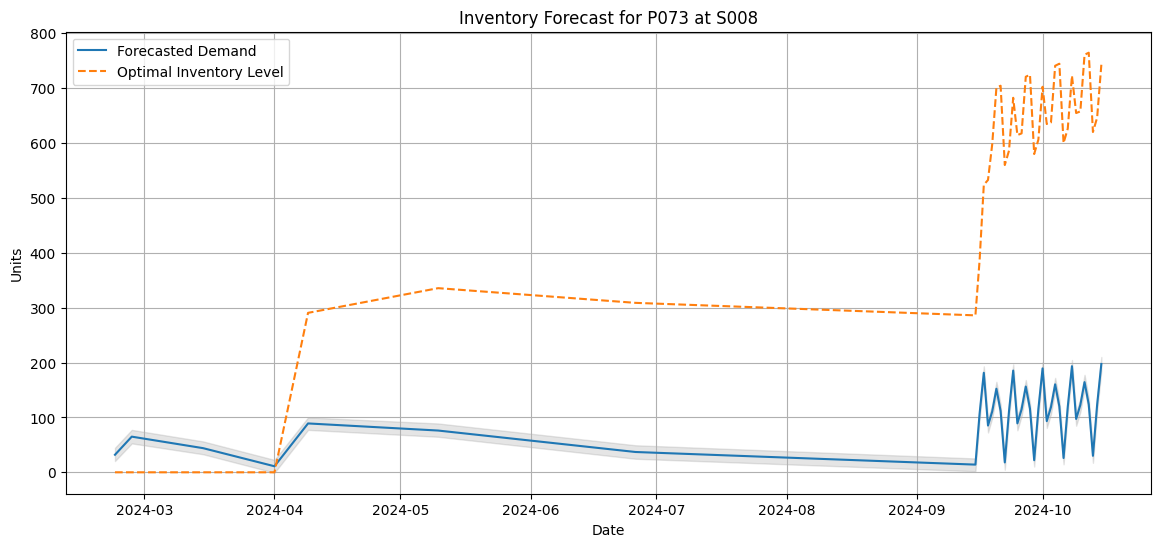

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Demand')
plt.plot(forecast['ds'], forecast['optimal_inventory'], label='Optimal Inventory Level', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color='gray')
plt.title(f'Inventory Forecast for {product} at {store}')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
forecast_export = forecast[['ds', 'yhat', 'optimal_inventory']]
forecast_export.to_csv(f'inventory_forecast_{product}_{store}.csv', index=False)


